## Code to compare the performance of QuakeFlow to conventional catalogs

Goals for this code:

1) Compare picks. For positive matches, calculate mean residual and standard deviation of residuals. Also calculate false positives and false negatives, to yield precision, recall, and F1-score. *TO-DO: decide how to evaluate new picks from PhaseNet that might be correct!

2) TO-DO: Compare association. For earthquakes that match, compare their locations and number of picks and which stations had picks. 

In [28]:
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import requests
import json
import obspy
from obspy.clients.fdsn import Client
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load in results from QuakeFlow from a response json file:

In [82]:
load_file = 'result_all'

In [83]:
f = open(load_file+'.json')
result = json.load(f)

catalog_gamma = result["catalog"]
picks_gamma = result["picks"]
df = pd.DataFrame(picks_gamma)
df['timestamp']=pd.to_datetime(df['timestamp'],infer_datetime_format=True)
df.head()

id               timestamp      prob           amp type  event_idx  \
0  AK.BCP..BH 2018-05-25 12:36:41.094  0.877103  1.821830e-06    p         -1   
1  AK.BCP..BH 2018-05-25 12:36:43.794  0.512018  1.821830e-06    s         -1   
2  AK.BCP..BN 2018-05-25 12:36:41.194  0.390691  1.649488e-06    p         -1   
3  AK.BCP..BN 2018-05-25 12:36:41.274  0.328402  8.093158e-07    s         -1   
4  AK.BCP..BN 2018-05-25 12:36:43.854  0.476192  1.649488e-06    s         -1   

   prob_gmma  
0         -1  
1         -1  
2         -1  
3         -1  
4         -1

#### Load in the original catalog information:

In [84]:
# Load master pick list
ground_truth = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_picks.parquet')
events = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_events.parquet')

In [85]:
ground_truth['og_timestamp']=pd.to_datetime(ground_truth['og_timestamp'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')
events['time']=pd.to_datetime(events['time'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')

In [86]:
ground_truth.head()

og_phase  arr_id     sta_code  pick_id            og_timestamp og_channel
0        s     125  XO.EP15..HH      125 2018-12-01 13:45:47.290        HHN
1        s     125   AV.PVV..SH      125 2019-06-01 09:36:36.644        SHZ
2        s     125  AK.FALS..BH      125 2019-01-01 05:06:32.877        BHN
3        s     125  XO.WD61..HH      125 2019-07-01 04:05:37.933        HHZ
4        s     125  AV.Q18K..BH      125 2018-07-01 02:36:30.270        BHZ

## Let's compare picks between PhaseNet and the original catalog.

#### Now, see which picks are true positives by joining based on phase type, station code, and time residual within a threshold.

In [87]:
resid_max = 1 # seconds

# Let's only compare the part of the original catalog that we have PhaseNet picks for:
cat_start = min(df['timestamp'] - pd.Timedelta(30,'seconds'))
cat_end = max(df['timestamp'] + pd.Timedelta(30,'seconds'))
ground_truth = ground_truth[(ground_truth['og_timestamp'] > cat_start) & (ground_truth['og_timestamp'] < cat_end)]

# Sort both dataframes by time:
df.sort_values(by=['timestamp'],inplace=True)
ground_truth.sort_values(by=['og_timestamp'],inplace=True)

# Merge dataframes, only merging picks if they have matching station ID, 
# phase type, and are within 0.1 s of each other
comp = pd.merge_asof(left=df,right=ground_truth,left_on=['timestamp'],right_on=['og_timestamp'],left_by=['id','type'],right_by=['sta_code','og_phase'],tolerance = pd.Timedelta(resid_max,'seconds'),direction='nearest')

# Add residual column: 
comp['pick_resid'] = comp['og_timestamp'] - comp['timestamp']
comp['pick_resid'] = comp['pick_resid'].dt.total_seconds()

In [12]:
comp

id               timestamp      prob           amp type  \
0     AK.CHN..BN 2018-05-25 12:36:29.998  0.466536  3.203228e-07    p   
1     AK.SWD..BN 2018-05-25 12:36:29.998  0.540268  6.030110e-07    p   
2    TA.M22K..BH 2018-05-25 12:36:30.858  0.326681  8.115038e-07    s   
3    XO.KS03..HN 2018-05-25 12:36:33.428  0.634112  1.980176e-06    s   
4    XO.KS03..HH 2018-05-25 12:36:33.428  0.474081  2.778105e-06    s   
..           ...                     ...       ...           ...  ...   
504  AK.CAPN..BN 2018-05-25 13:06:26.224  0.391648  1.867978e-06    p   
505  XO.KD01..HH 2018-05-25 13:06:26.934  0.330624  1.190106e-06    p   
506  AT.CHGN..BH 2018-05-25 13:06:29.474  0.452366  8.247926e-07    p   
507  XO.KS03..HH 2018-05-25 13:06:29.504  0.717360  1.093578e-06    p   
508  XO.LA25..HH 2018-05-25 13:06:29.534  0.404498  6.218916e-06    p   

     event_idx  prob_gmma og_phase  arr_id sta_code  pick_id og_timestamp  \
0           -1         -1      NaN     NaN      NaN      NaN          NaT   
1           -1         -1      NaN     NaN      NaN      NaN          NaT   
2           -1         -1      NaN     NaN      NaN      NaN          NaT   
3           -1         -1      NaN     NaN      NaN      NaN          NaT   
4           -1         -1      NaN     NaN      NaN      NaN          NaT   
..         ...        ...      ...     ...      ...      ...          ...   
504         -1         -1      NaN     NaN      NaN      NaN          NaT   
505         -1         -1      NaN     NaN      NaN      NaN          NaT   
506         -1         -1      NaN     NaN      NaN      NaN          NaT   
507         -1         -1      NaN     NaN      NaN      NaN          NaT   
508         -1         -1      NaN     NaN      NaN      NaN          NaT   

    og_channel  pick_resid  
0          NaN         NaN  
1          NaN         NaN  
2          NaN         NaN  
3          NaN         NaN  
4          NaN         NaN  
..         ...         ...  
504        NaN         NaN  
505        NaN         NaN  
506        NaN         NaN  
507        NaN         NaN  
508        NaN         NaN  

[509 rows x 14 columns]

#### Use the merged dataframe to calculate performance metrics:

In [88]:
true_positives = comp['og_timestamp'].notna().sum()

false_positives = comp['og_timestamp'].isna().sum()

false_negatives = len(ground_truth)-true_positives

print('There were ' + str(true_positives) + ' true positives.')
print('There were ' + str(false_positives) + ' false positives.')
print('There were ' + str(false_negatives) + ' false negatives.')

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * ((precision * recall)/(precision + recall))

print('This yields a precision of ' + str(round(precision,2)) + ', a recall of ' + str(round(recall,2)) + ', and an F1-score of ' + str(round(f1,2)) + '.')

There were 42 true positives.
There were 1662 false positives.
There were 1833 false negatives.
This yields a precision of 0.02, a recall of 0.02, and an F1-score of 0.02.


In [38]:
comp[comp['og_timestamp'].isna()]

id               timestamp      prob           amp type  \
0     CN.BVCY..HH 2018-05-25 12:36:30.004  0.461323  5.196243e-07    p   
1     AK.WAT1..HN 2018-05-25 12:36:30.004  0.309661  7.282834e-07    p   
2      AK.SWD..BN 2018-05-25 12:36:30.004  0.648439  6.030022e-07    p   
3      AK.SAW..BN 2018-05-25 12:36:30.004  0.354177  6.194221e-07    p   
4      AK.RAG..BN 2018-05-25 12:36:30.004  0.525291  2.015866e-06    p   
...           ...                     ...       ...           ...  ...   
1699  CN.BVCY..HH 2018-05-25 13:06:29.494  0.984105  2.568596e-07    p   
1700  XO.KS03..HH 2018-05-25 13:06:29.504  0.708751  1.093578e-06    p   
1701  XO.LA25..HH 2018-05-25 13:06:29.614  0.379863  6.218916e-06    p   
1702   AK.WAX..BH 2018-05-25 13:06:29.614  0.307097  4.246299e-07    p   
1703   AK.TRF..BH 2018-05-25 13:06:29.774  0.310178  2.772038e-07    s   

      event_idx  prob_gmma og_phase  arr_id sta_code  pick_id og_timestamp  \
0            -1         -1      NaN     NaN      NaN      NaN          NaT   
1            -1         -1      NaN     NaN      NaN      NaN          NaT   
2            -1         -1      NaN     NaN      NaN      NaN          NaT   
3            -1         -1      NaN     NaN      NaN      NaN          NaT   
4            -1         -1      NaN     NaN      NaN      NaN          NaT   
...         ...        ...      ...     ...      ...      ...          ...   
1699         -1         -1      NaN     NaN      NaN      NaN          NaT   
1700         -1         -1      NaN     NaN      NaN      NaN          NaT   
1701         -1         -1      NaN     NaN      NaN      NaN          NaT   
1702         -1         -1      NaN     NaN      NaN      NaN          NaT   
1703         -1         -1      NaN     NaN      NaN      NaN          NaT   

     og_channel  pick_resid  
0           NaN         NaN  
1           NaN         NaN  
2           NaN         NaN  
3           NaN         NaN  
4           NaN         NaN  
...         ...         ...  
1699        NaN         NaN  
1700        NaN         NaN  
1701        NaN         NaN  
1702        NaN         NaN  
1703        NaN         NaN  

[1662 rows x 14 columns]

#### And residual statistics:

Mean residual was -0.33 seconds.
Residual standard deviation was 0.16 seconds.


<AxesSubplot:>

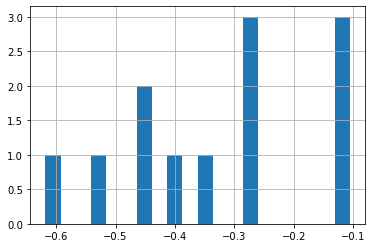

In [14]:
resid = comp['pick_resid'][comp['pick_resid'].notna()]

mean_resid = np.mean(resid)
std_resid = np.std(resid)

print('Mean residual was ' + str(round(mean_resid,2)) + ' seconds.')
print('Residual standard deviation was ' + str(round(std_resid,2)) + ' seconds.')

comp['pick_resid'].hist(bins=20)

In [15]:
resid_max = 0.1

true_positives = len(np.abs(comp['pick_resid'])<=resid_max)
false_positives = len(np.abs(comp['pick_resid'])>resid_max)
cross = pd.merge(left = df, right = ground_truth,how="outer", left_on=['id','type'],right_on=['sta_code','og_phase'])
# Picks that PhaseNet missed:
missed_picks = cross[cross['timestamp'].isna()]
false_negatives = len(missed_picks)

print('There were ' + str(true_positives) + ' true positives.')
print('There were ' + str(false_positives) + ' false positives.')
print('There were ' + str(false_negatives) + ' false negatives.')

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * ((precision * recall)/(precision + recall))

print('This yields a precision of ' + str(round(precision,2)) + ', a recall of ' + str(round(recall,2)) + ', and an F1-score of ' + str(round(f1,2)) + '.')


There were 509 true positives.
There were 509 false positives.
There were 1185 false negatives.
This yields a precision of 0.5, a recall of 0.3, and an F1-score of 0.38.


#### Make scatter plot through time of picks

In [80]:
events = events[(events['time'] > cat_start) & (events['time'] < cat_end)]
events

time  latitude  longitude    depth  num_arrivals  \
6596 2018-05-25 12:38:24.637   55.4865  -151.8552  39100.0            30   

                                            origin_id  
6596  quakeml:earthquake.alaska.edu/origin/0186o0aq9e

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

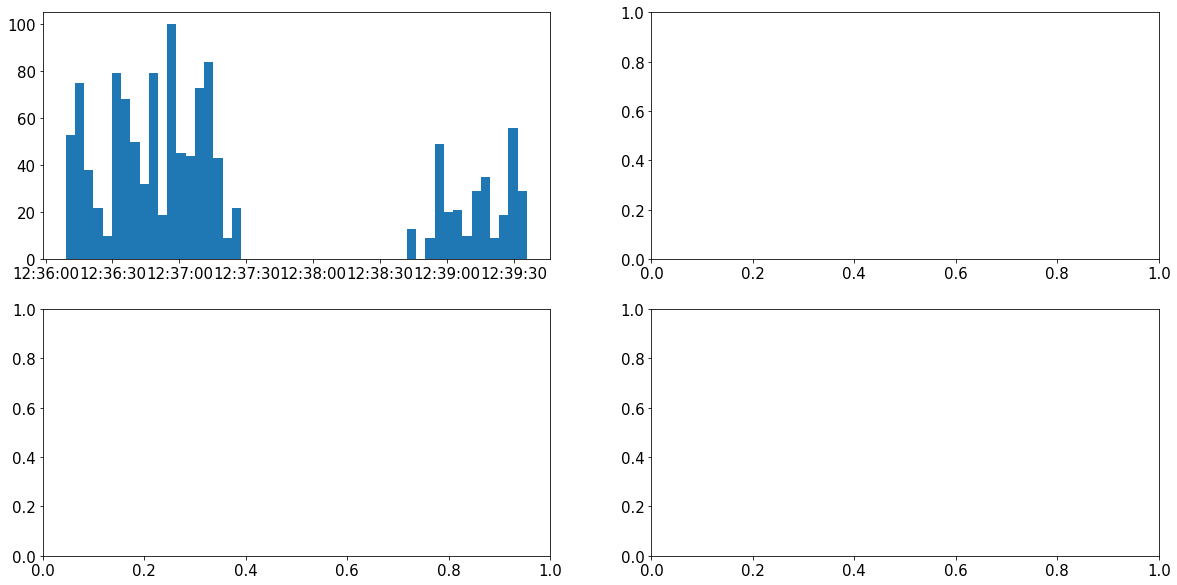

In [93]:
plt.rcParams.update({'font.size': 15})

php_picks = df[df['type']=='p']
phs_picks = df[df['type']=='s']

p_picks = ground_truth[ground_truth['og_phase']=='p']
s_picks = ground_truth[ground_truth['og_phase']=='s']

nbins= 50

fig, axs = plt.subplots(2,2, figsize=(20,10))
axs[0,0].hist(p_picks['og_timestamp'],bins=nbins);
axs[0,0].axvline(x=events['time'])
axs[0,0].set_title('Original P-picks')
axs[0,1].hist(s_picks['og_timestamp'],bins=nbins);
axs[0,1].set_title('Original S-picks')
axs[1,0].hist(php_picks['timestamp'],bins=nbins);
axs[1,0].set_title('PhaseNet P-picks')
axs[1,1].hist(phs_picks['timestamp'],bins=nbins);
axs[1,1].set_title('PhaseNet S-picks')



## Now let's take a closer look at the "new" picks that PhaseNet got, and see if they look real:



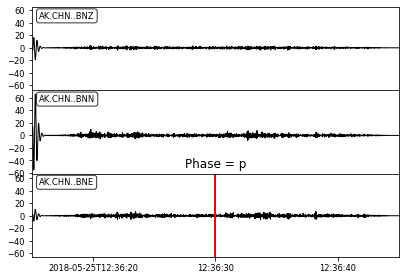

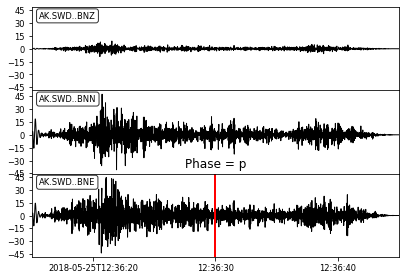

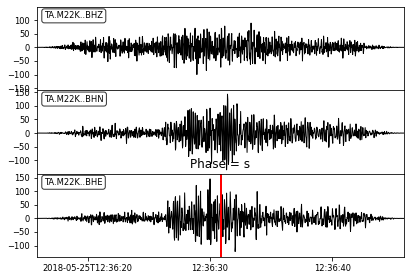

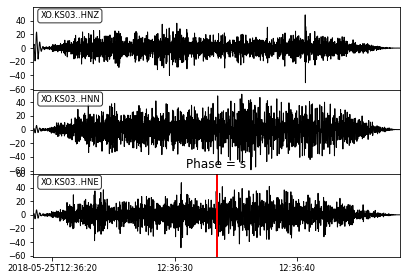

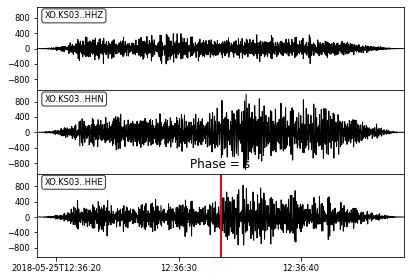

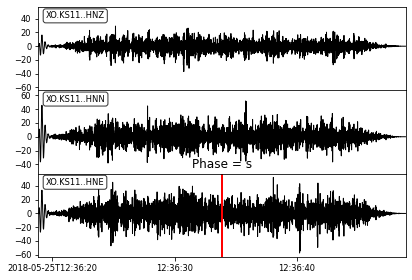

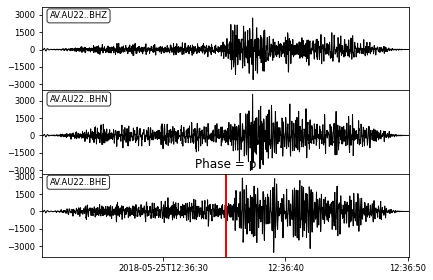

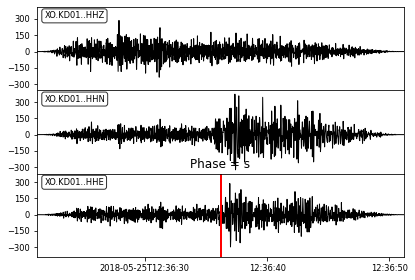

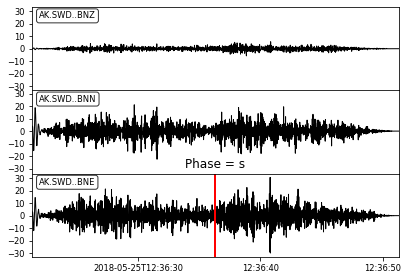

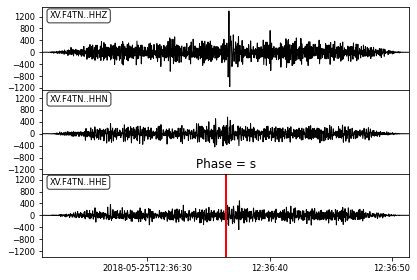

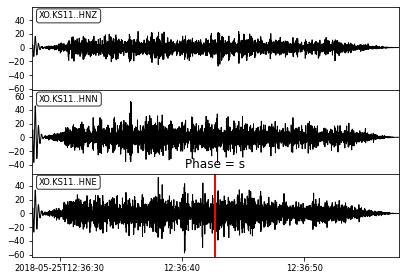

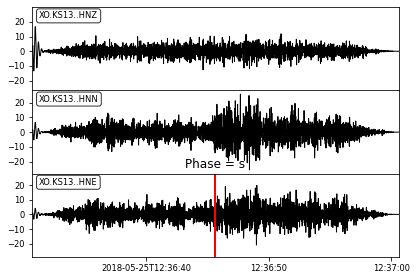

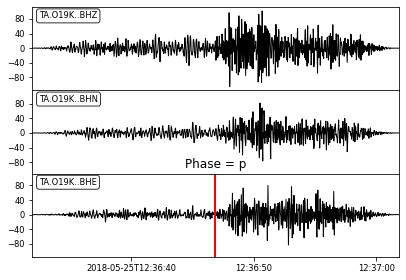

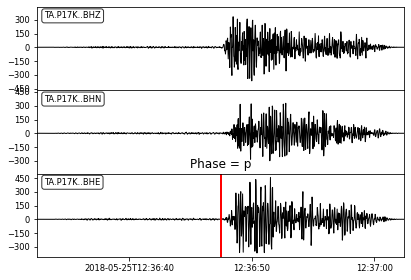

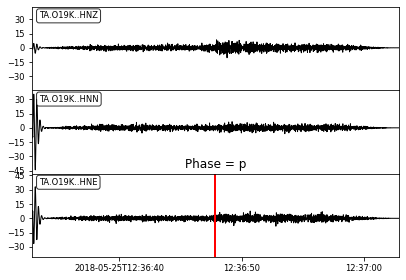

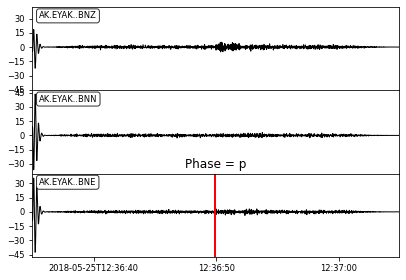

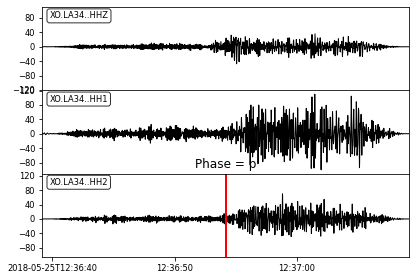

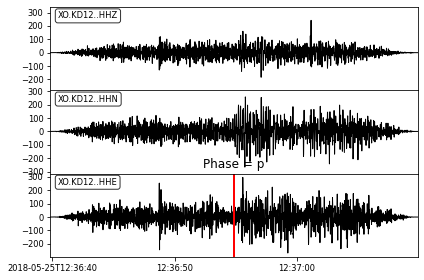

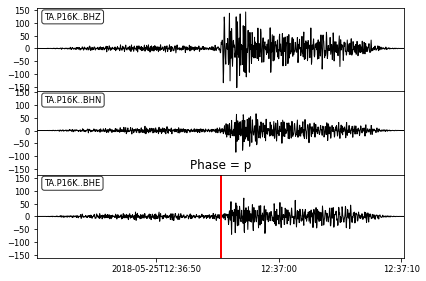

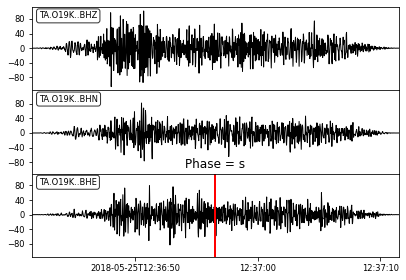

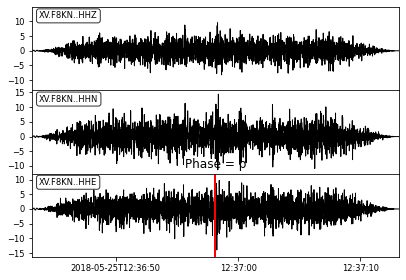

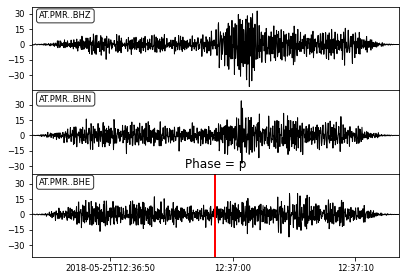

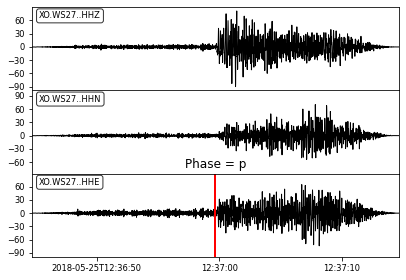

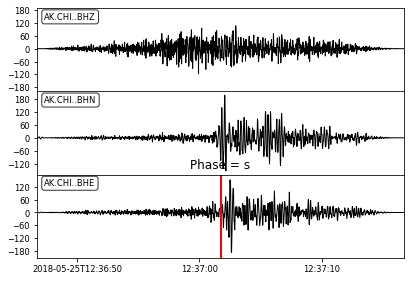

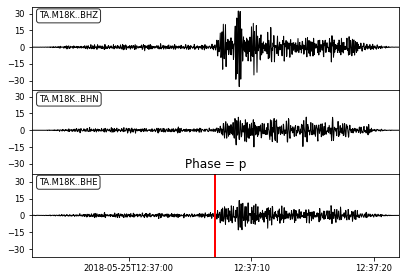

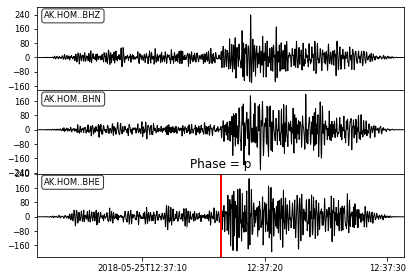

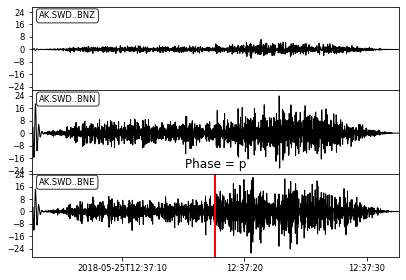

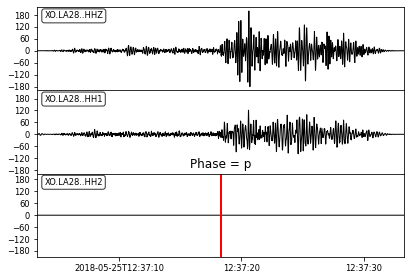

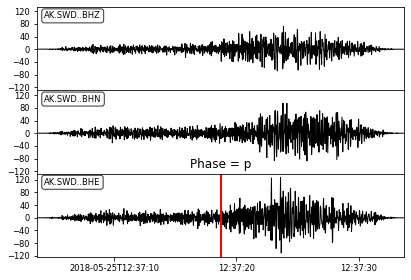

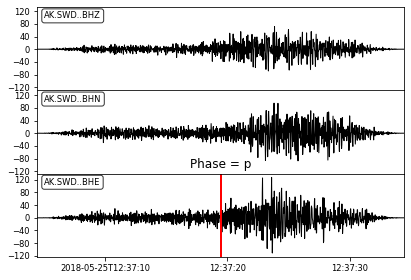

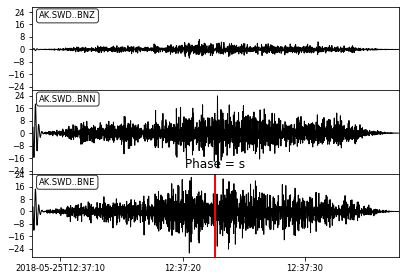

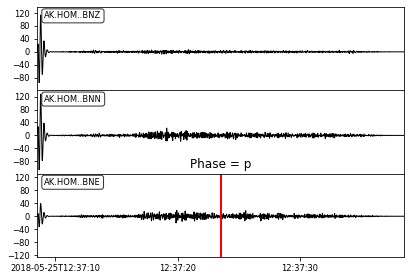

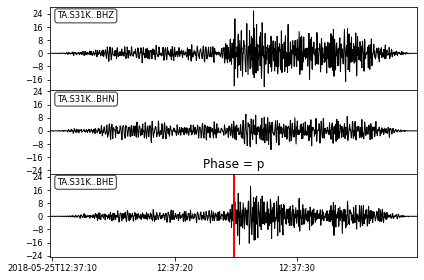

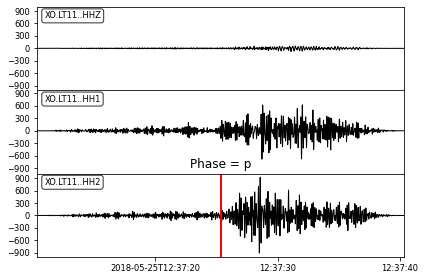

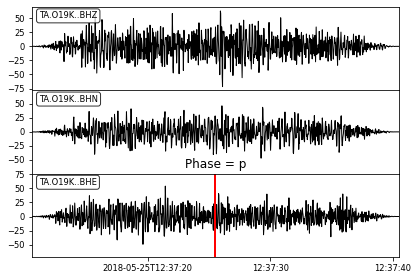

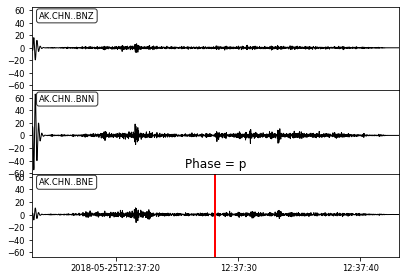

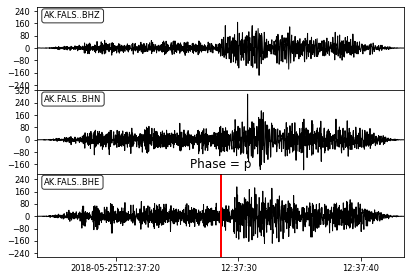

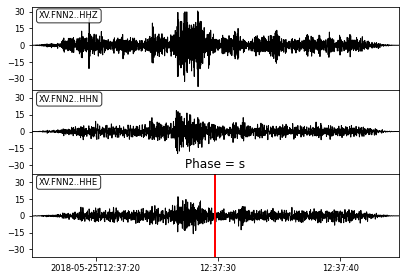

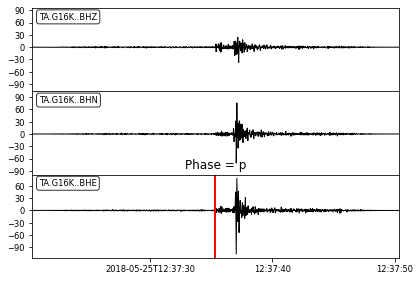

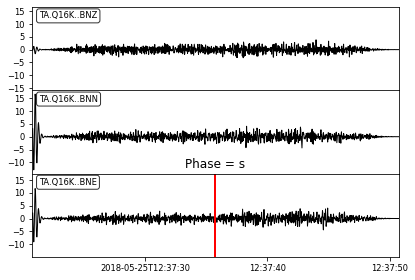

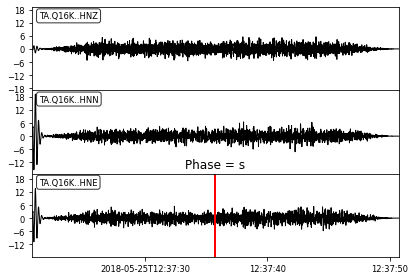

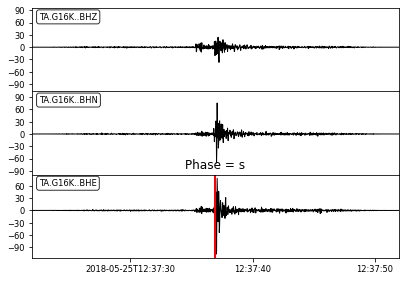

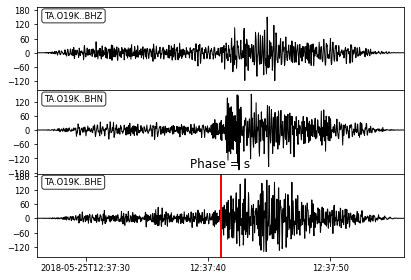

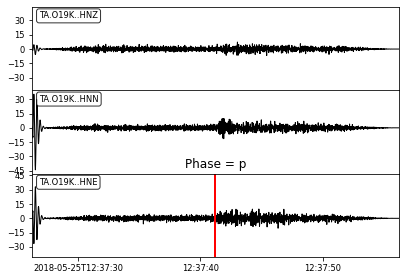

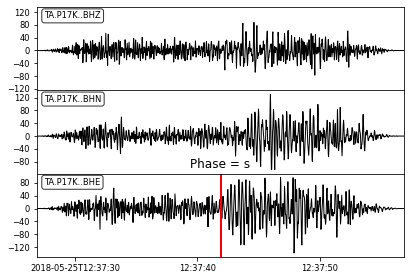

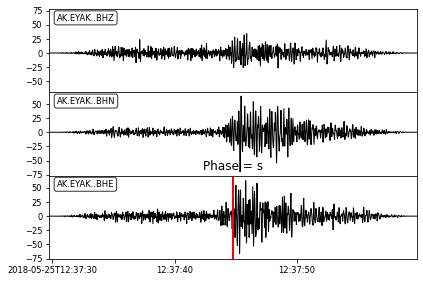

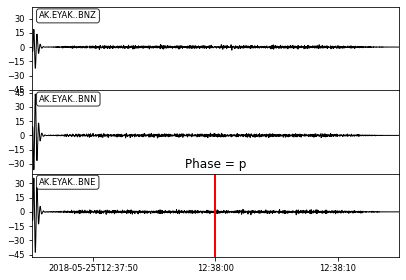

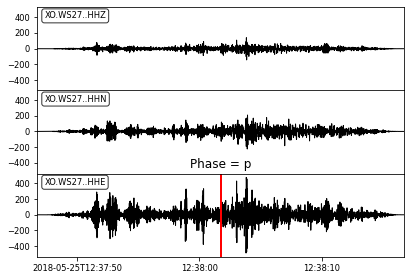

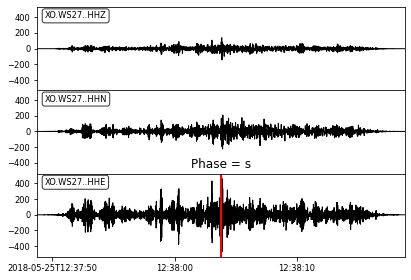

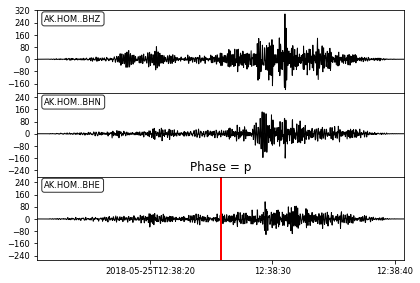

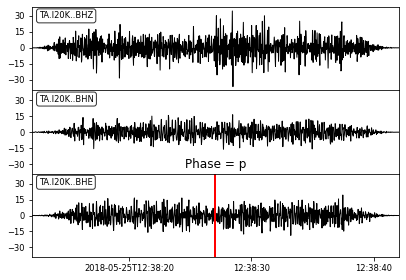

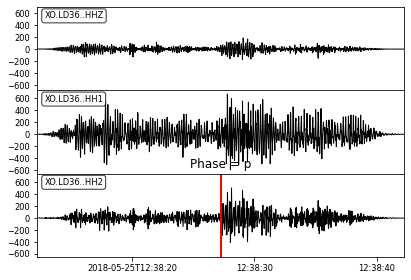

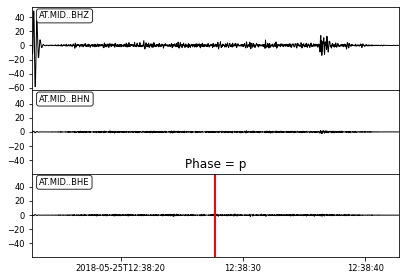

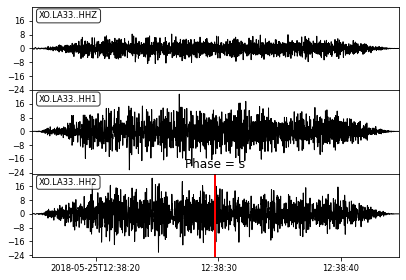

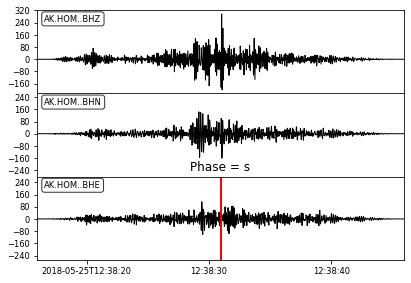

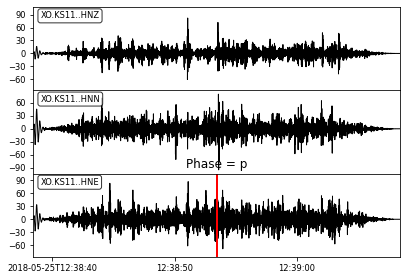

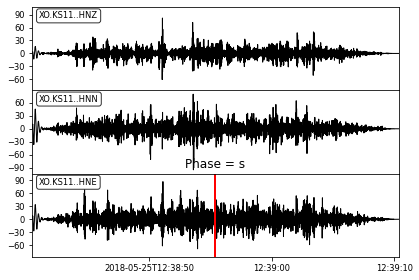

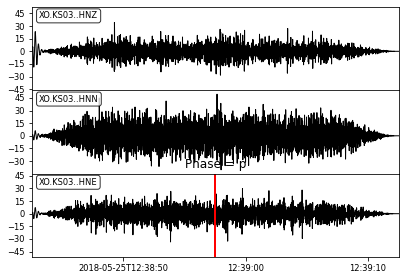

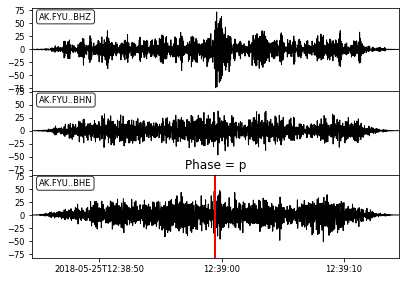

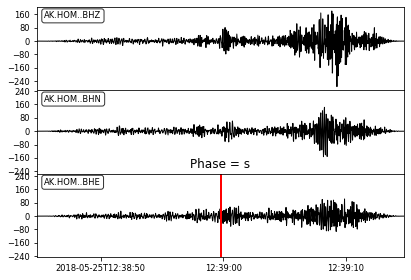

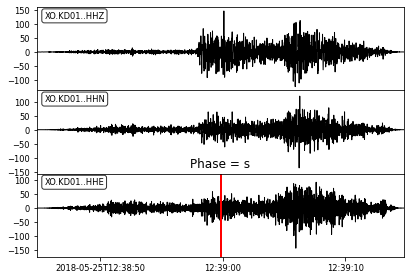

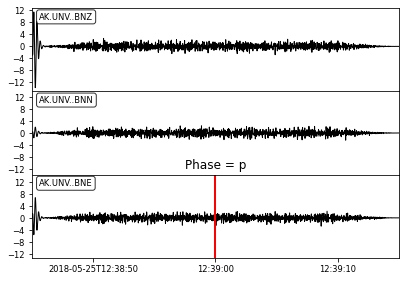

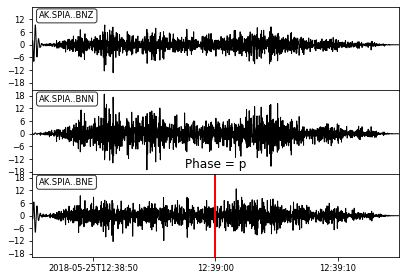

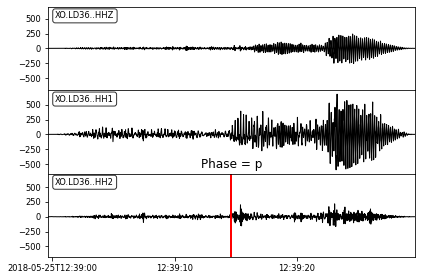

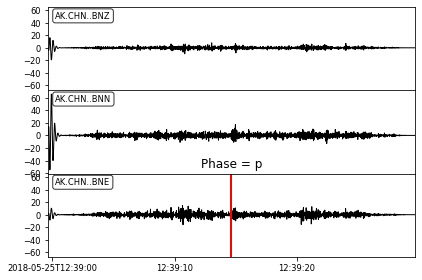

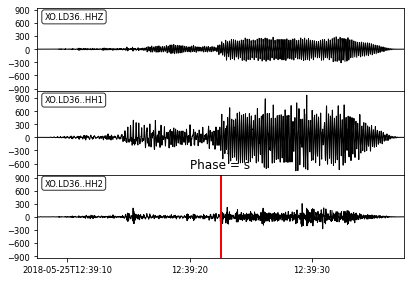

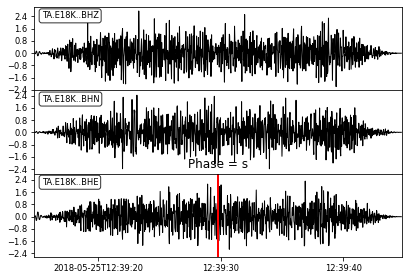

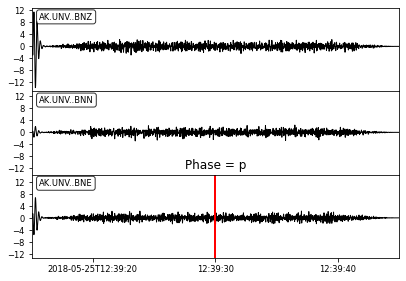

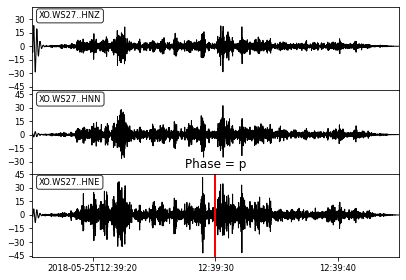

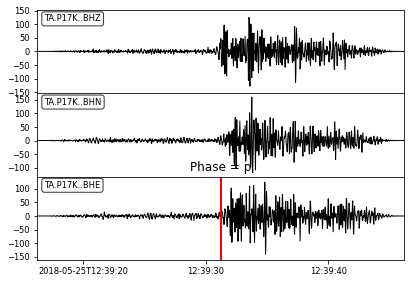

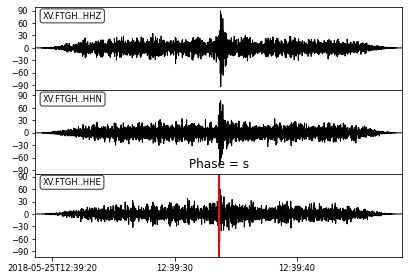

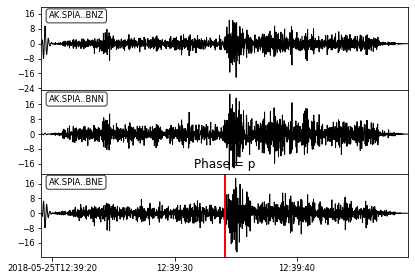

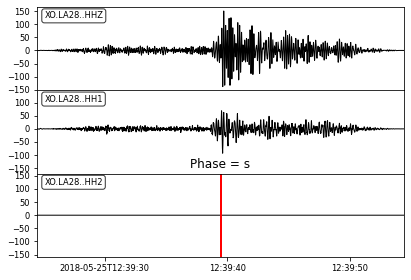

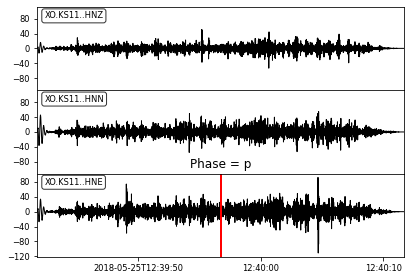

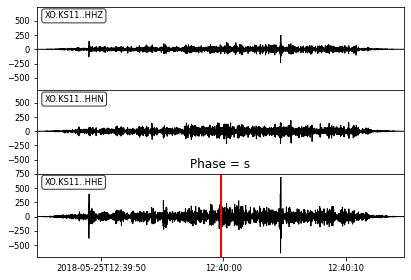

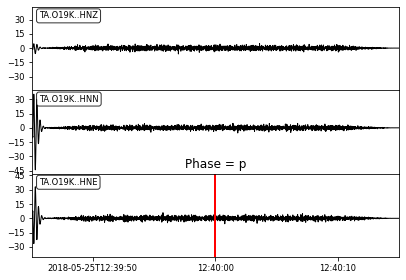

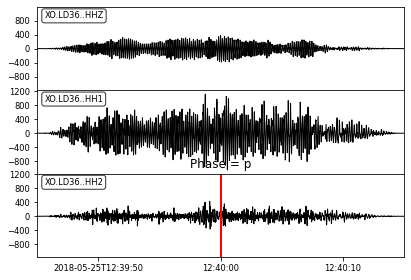

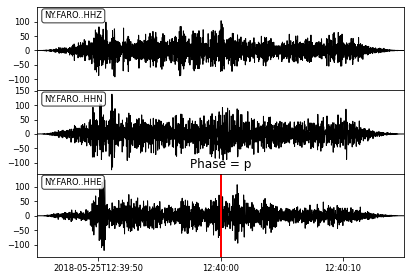

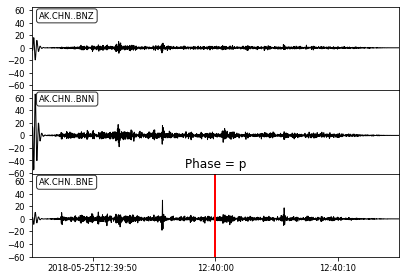

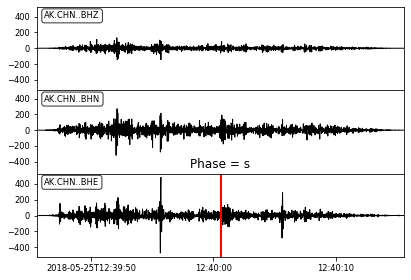

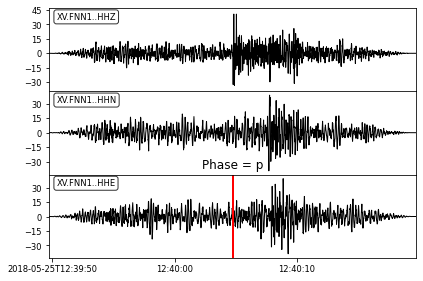

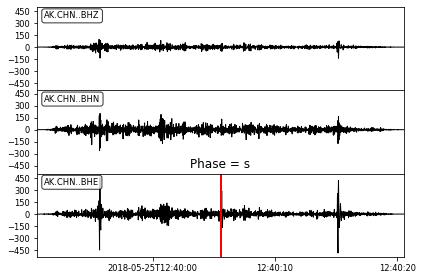

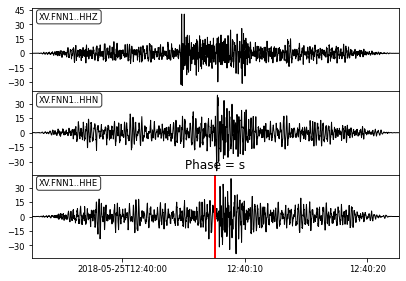

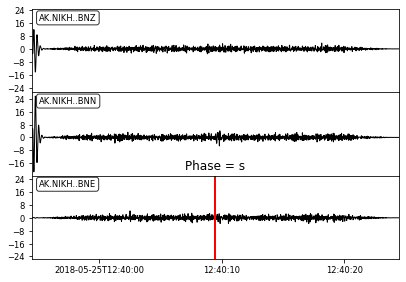

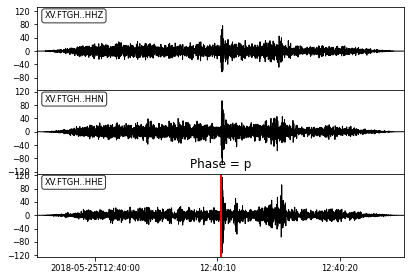

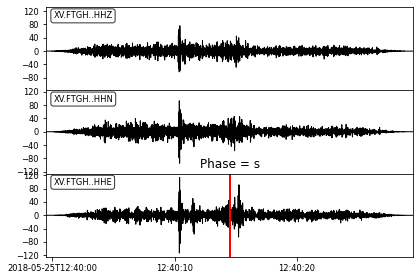

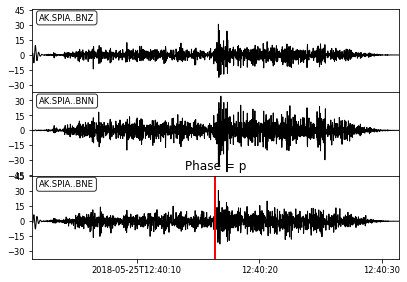

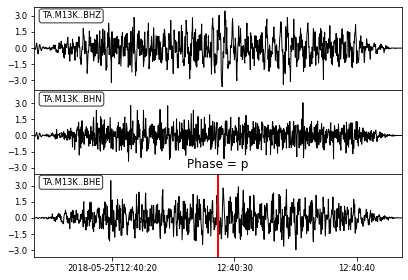

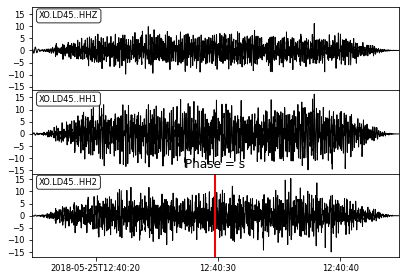

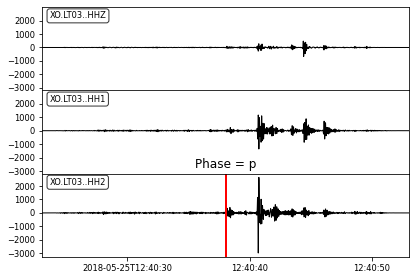

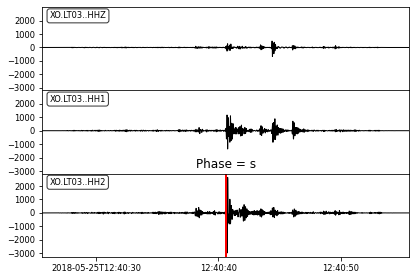

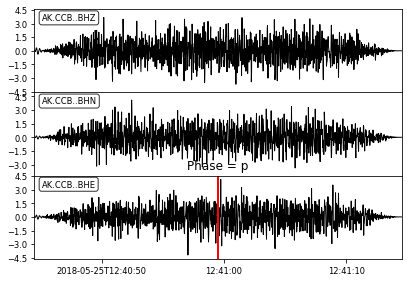

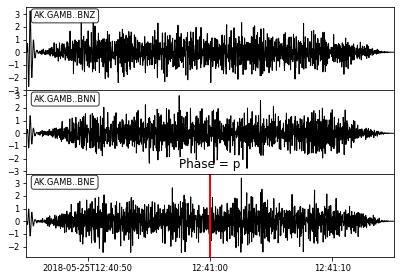

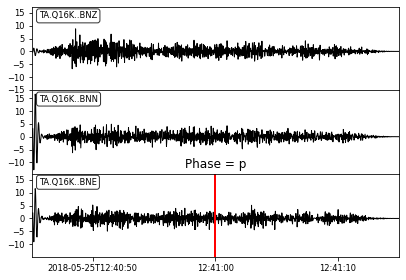

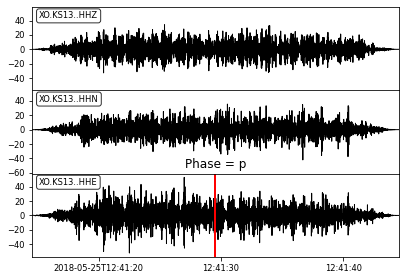

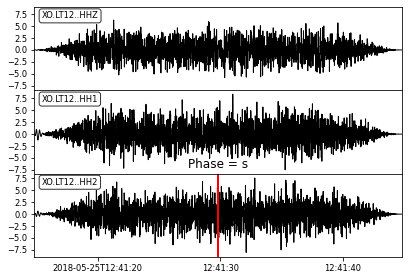

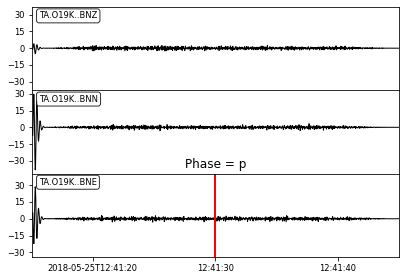

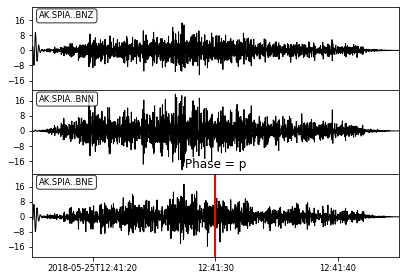

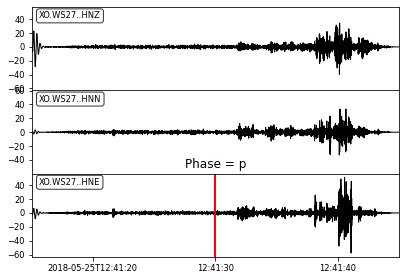

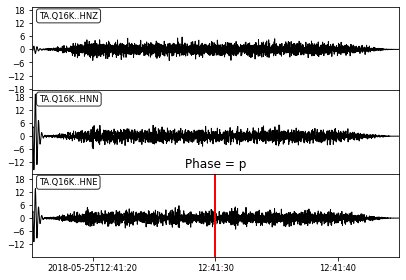

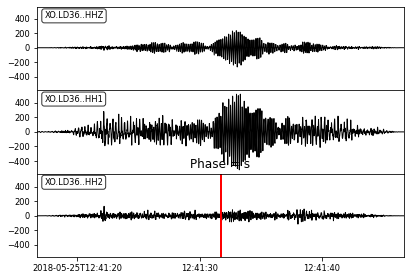

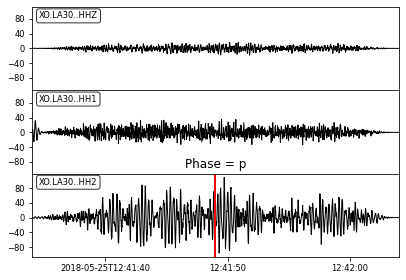

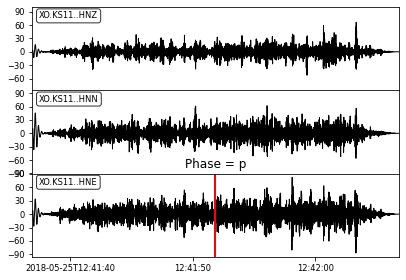

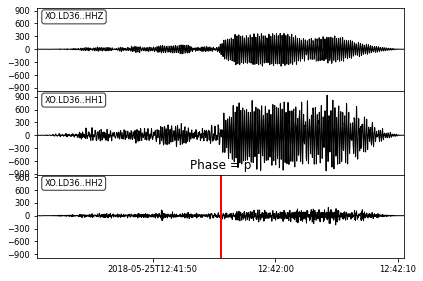

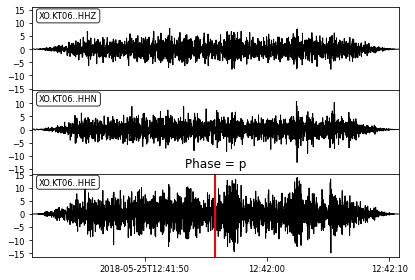

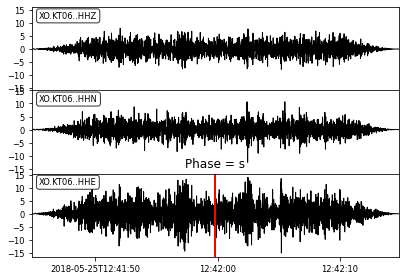

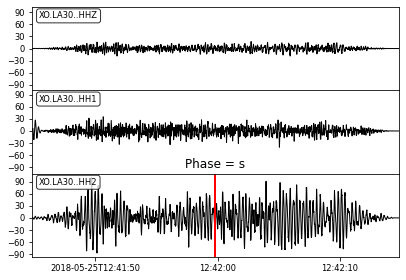

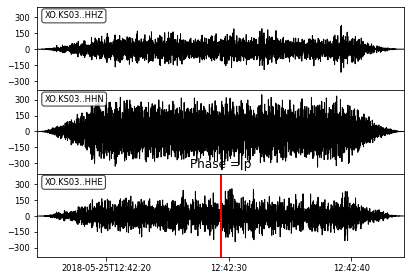

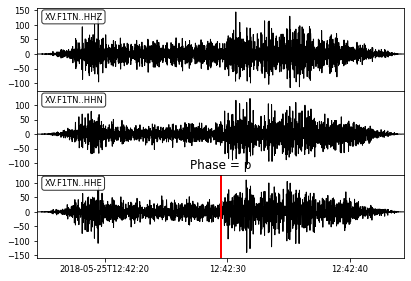

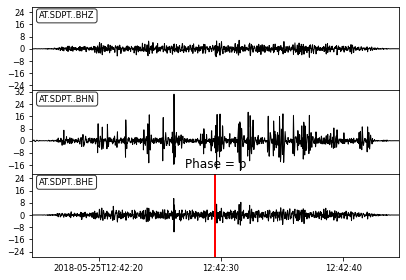

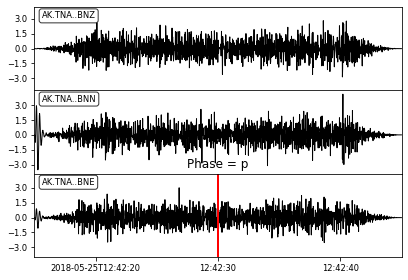

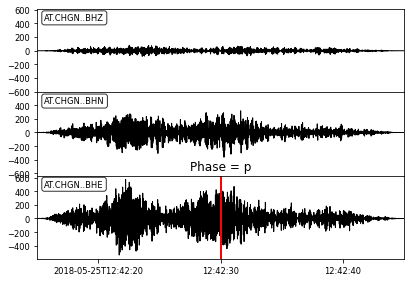

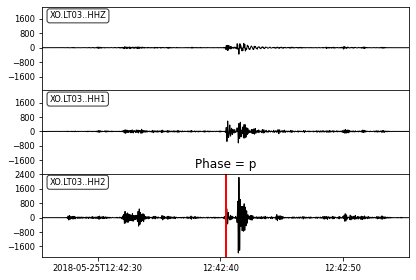

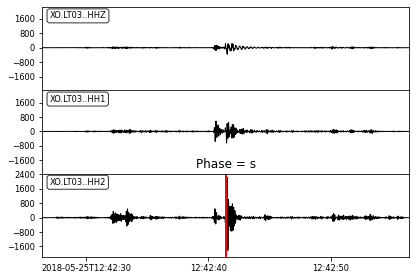

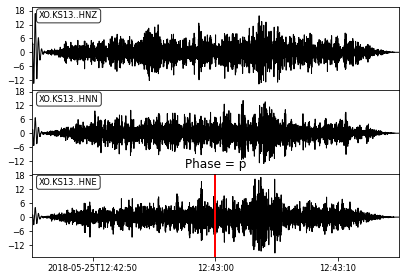

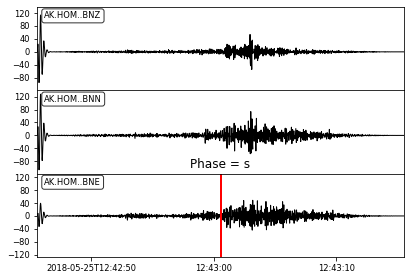

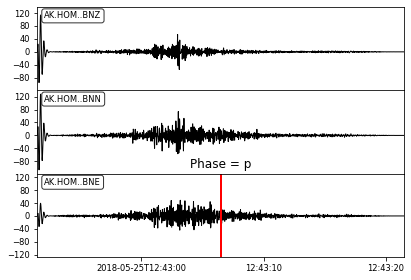

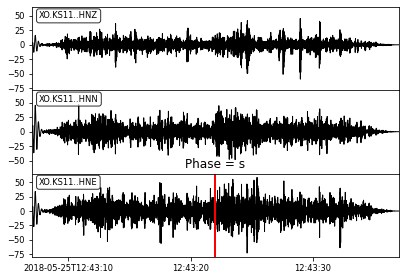

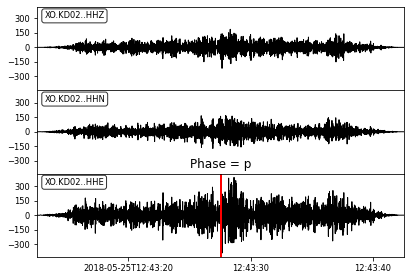

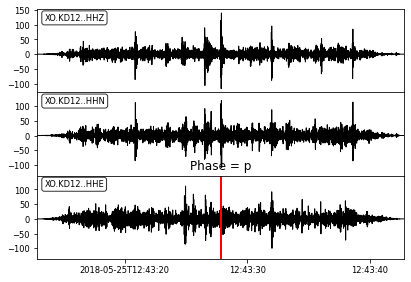

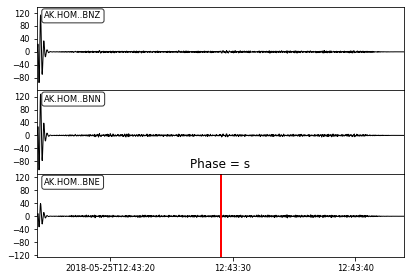

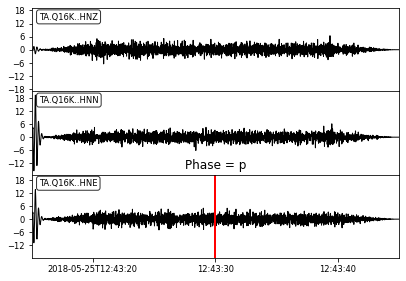

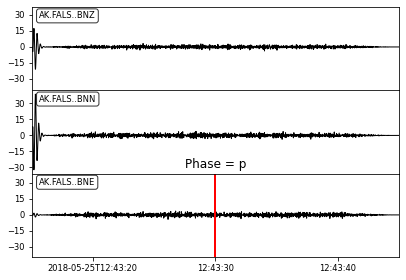

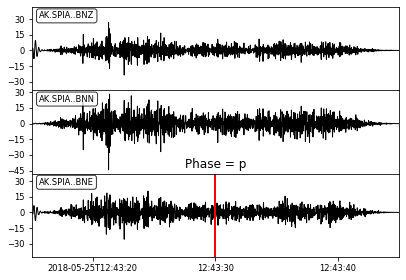

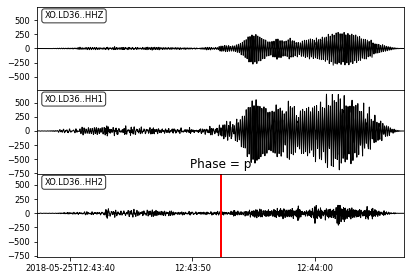

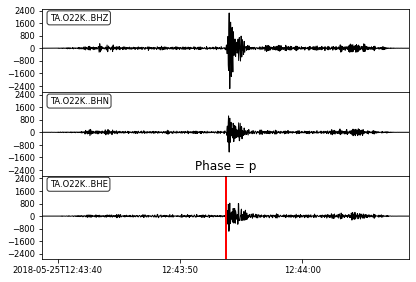

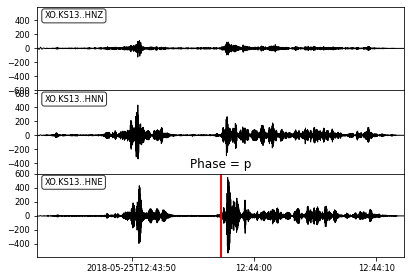

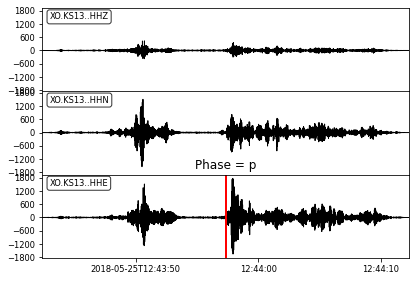

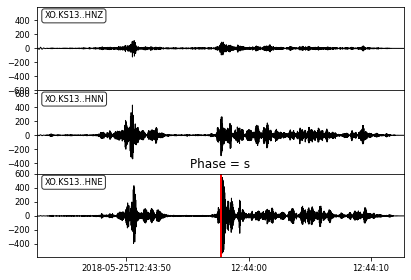

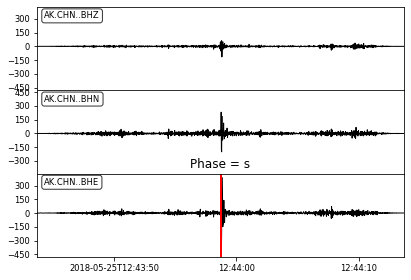

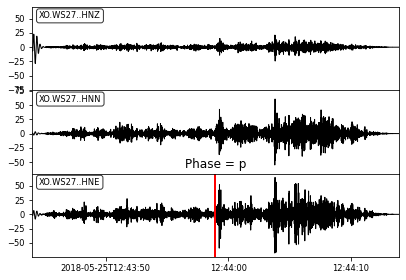

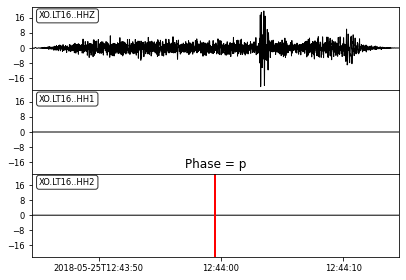

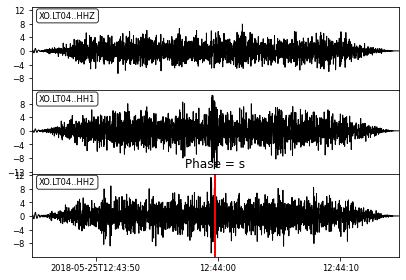

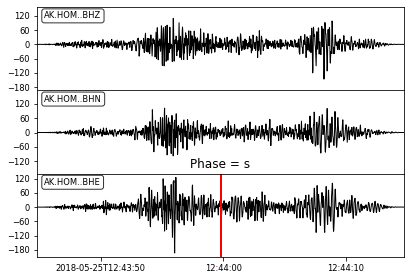

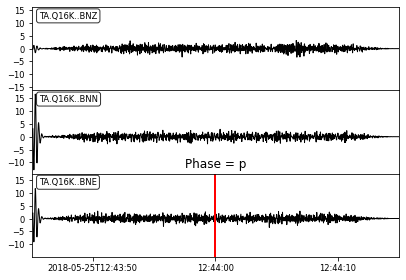

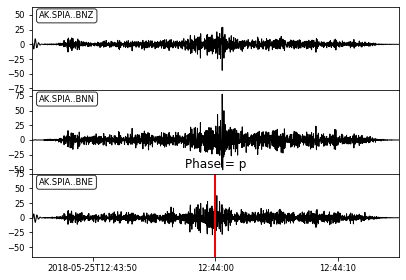

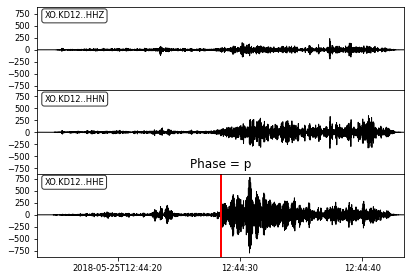

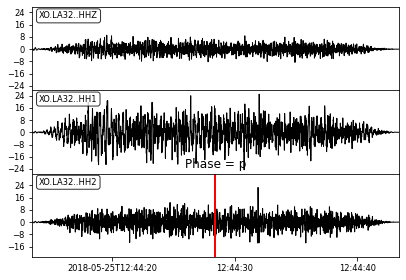

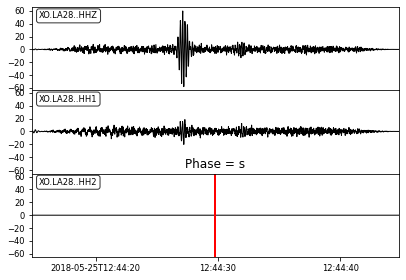

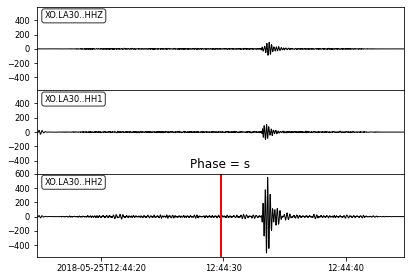

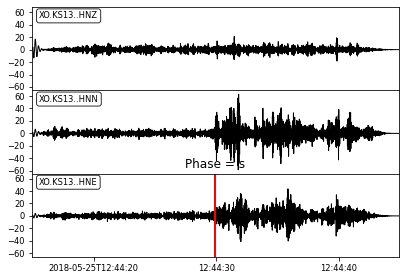

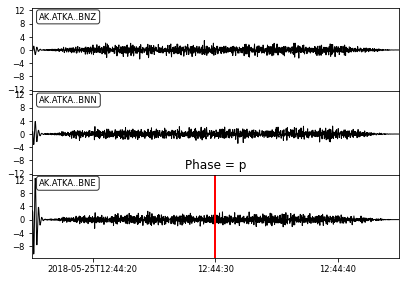

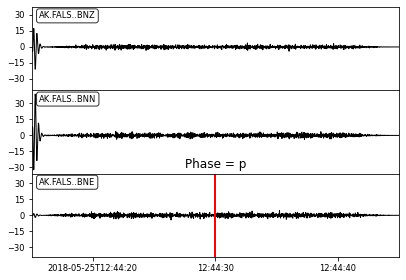

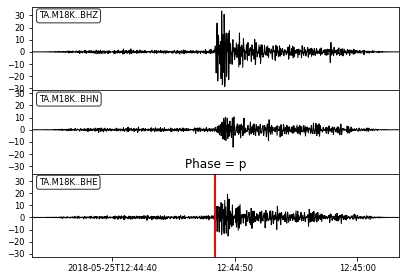

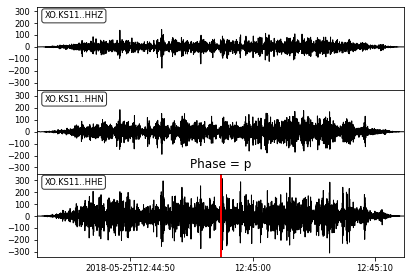

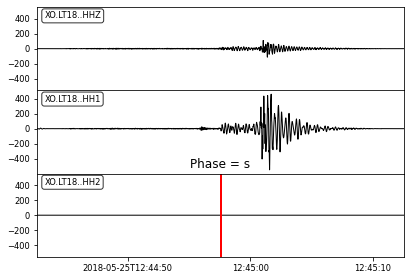

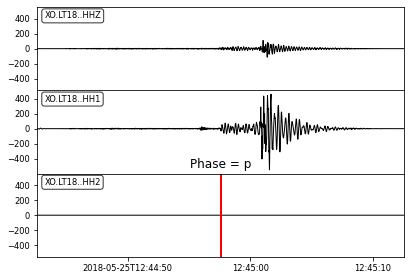

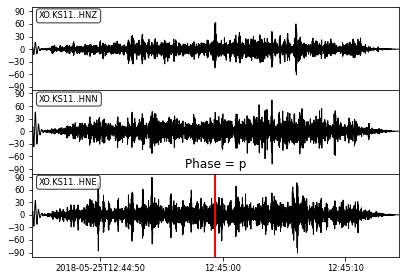

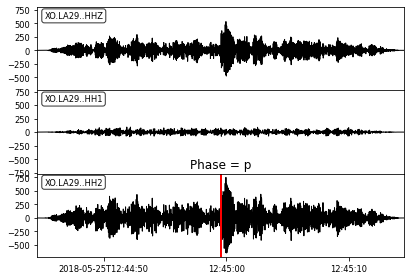

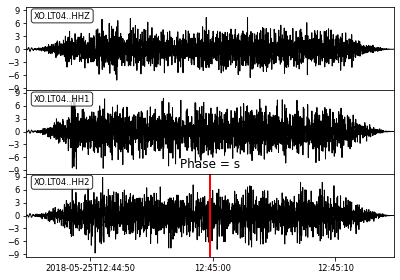

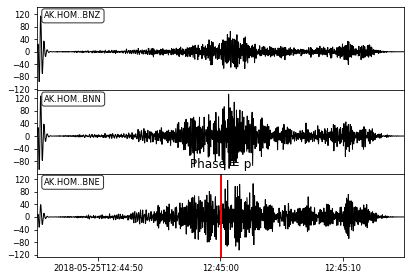

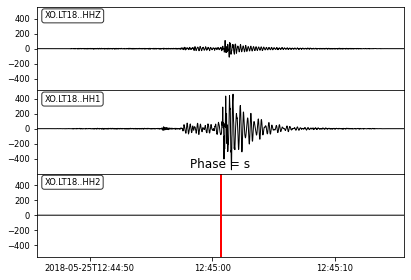

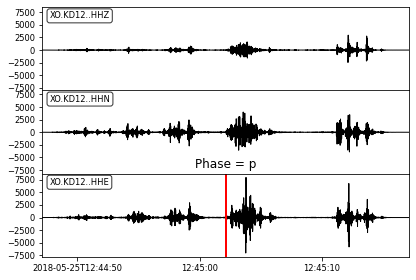

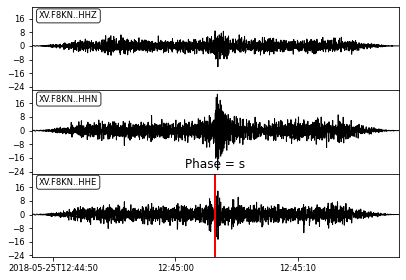

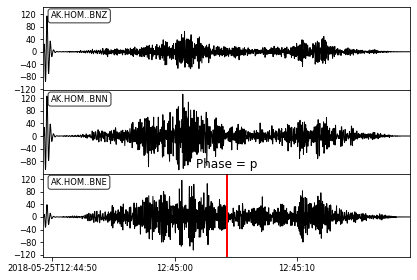

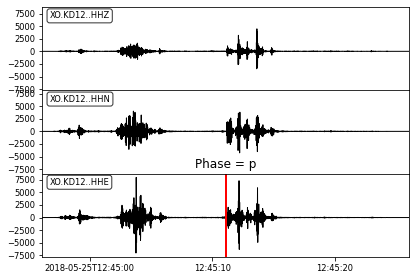

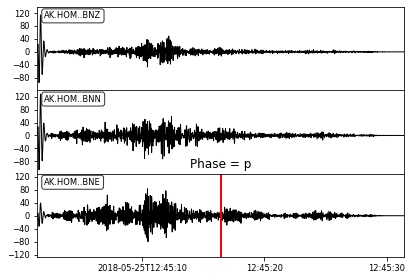

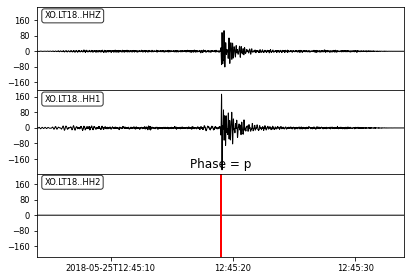

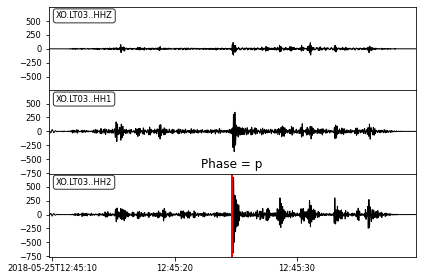

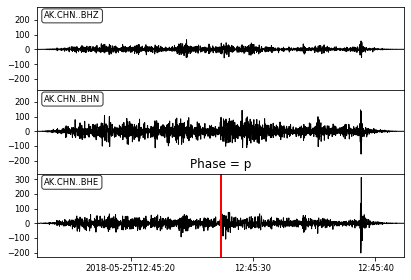

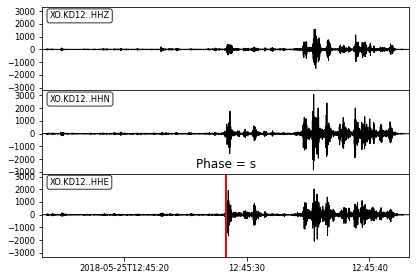

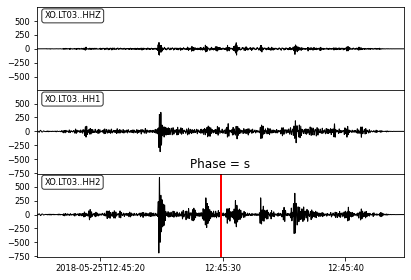

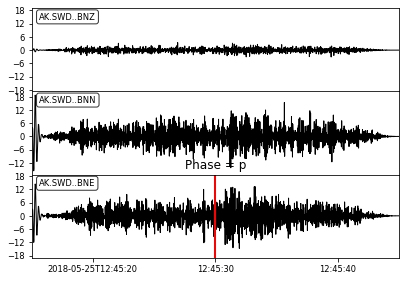

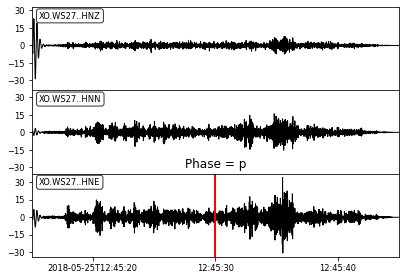

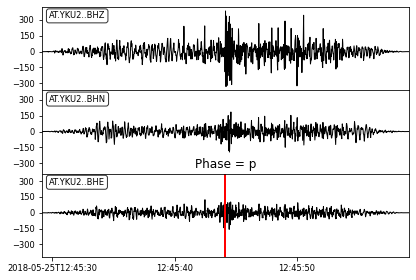

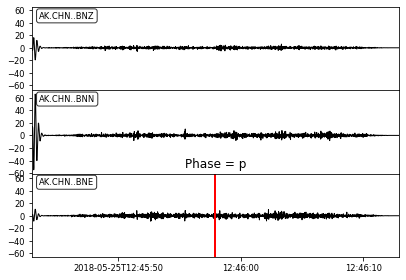

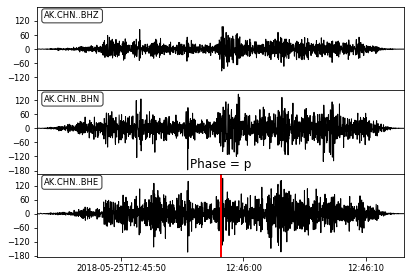

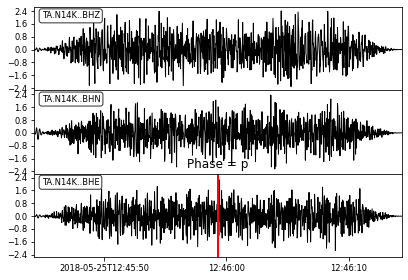

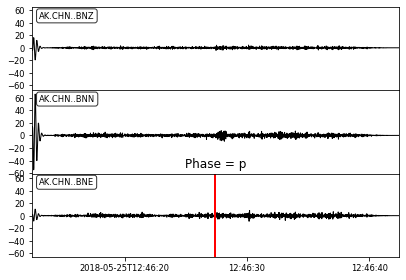

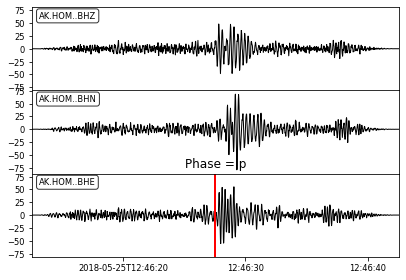

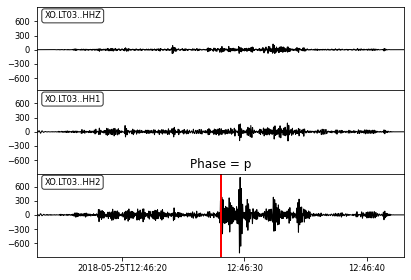

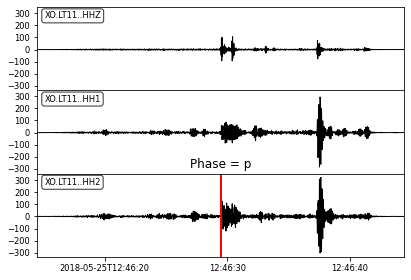

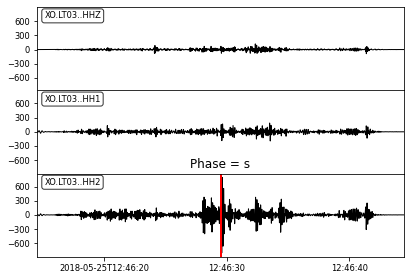

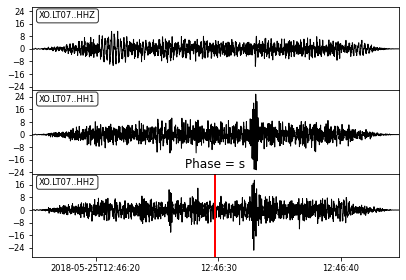

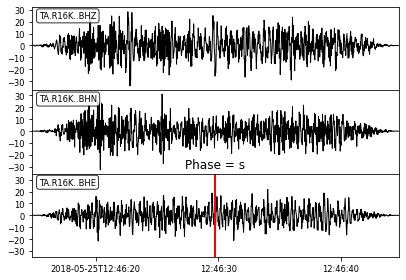

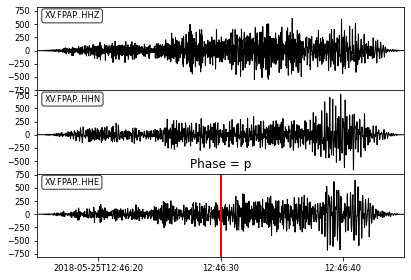

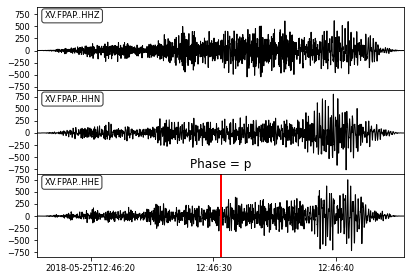

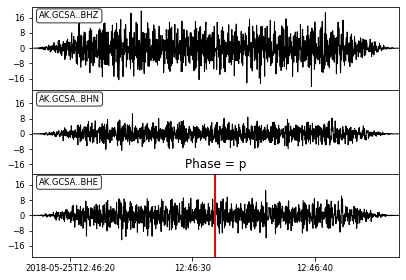

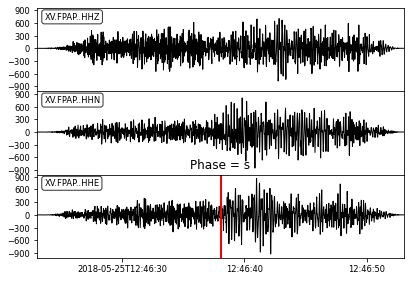

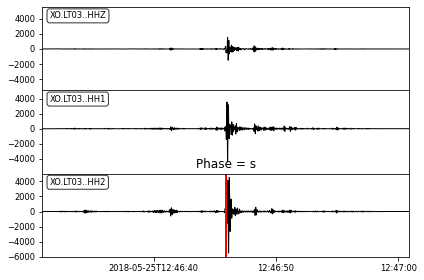

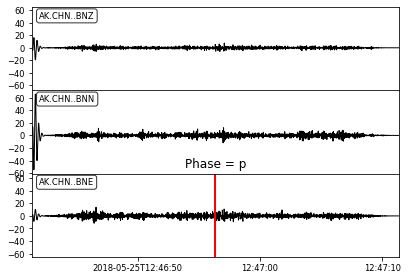

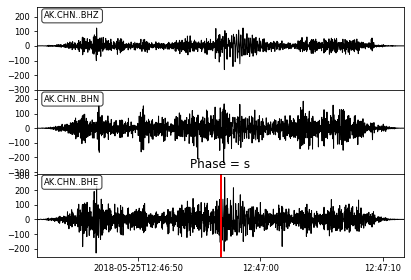

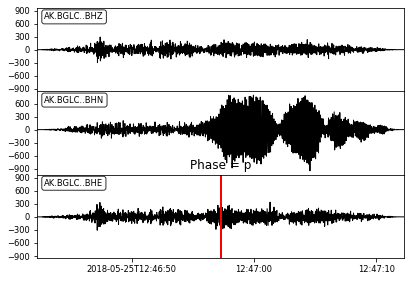

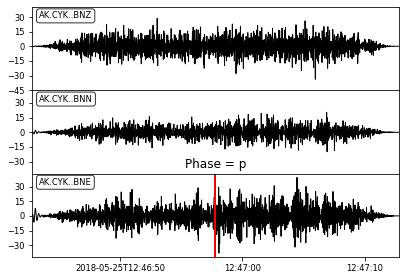

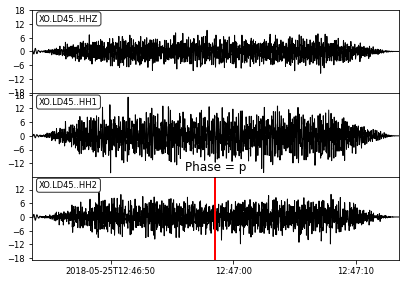

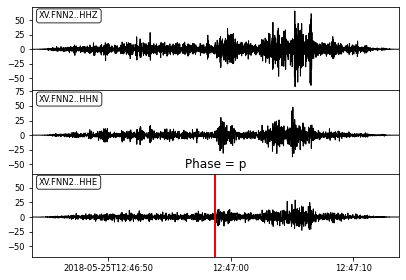

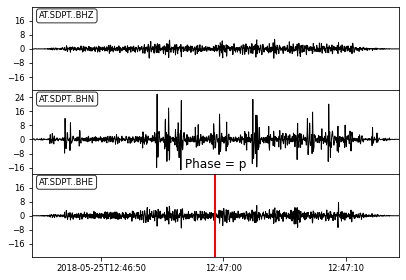

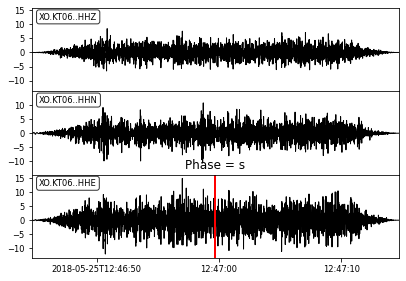

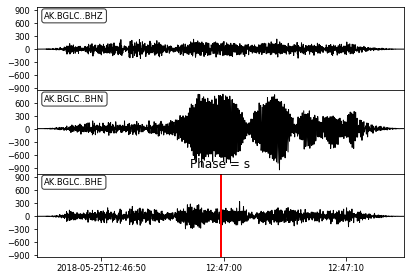

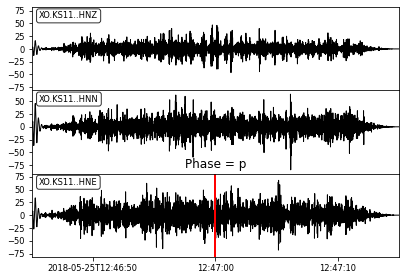

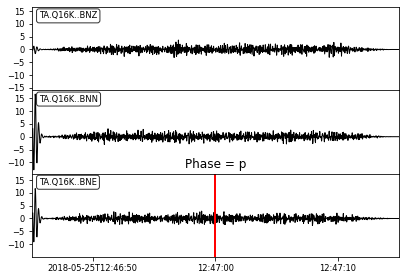

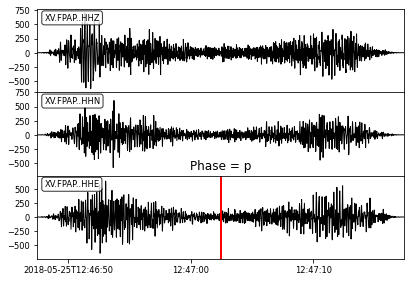

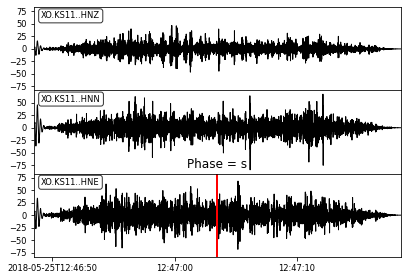

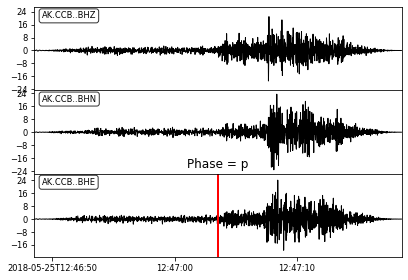

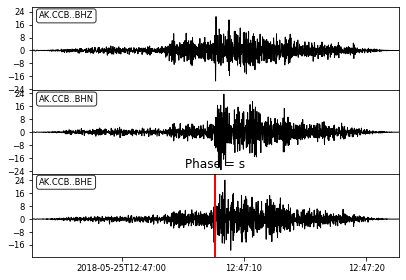

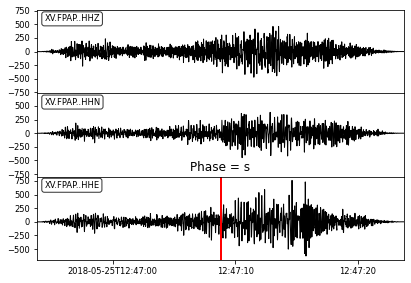

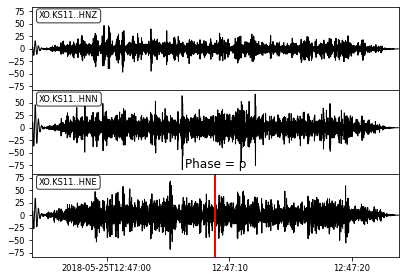

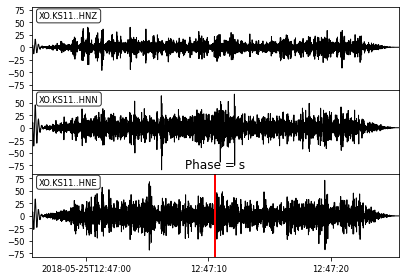

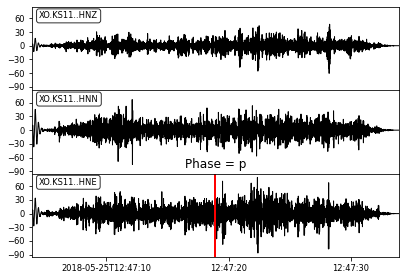

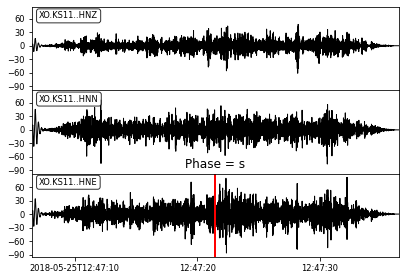

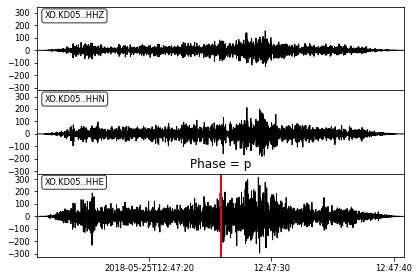

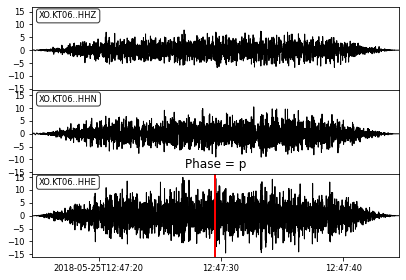

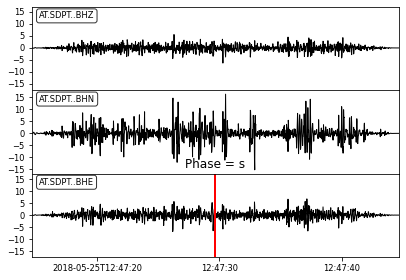

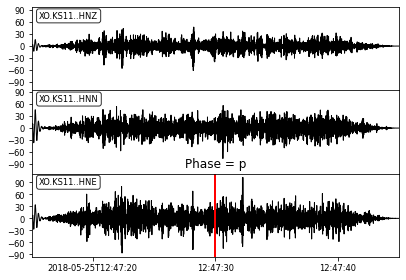

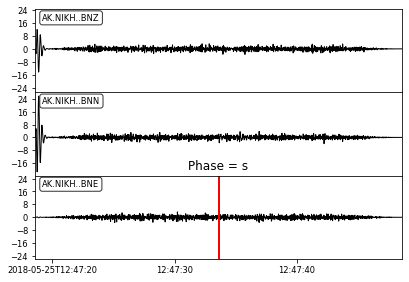

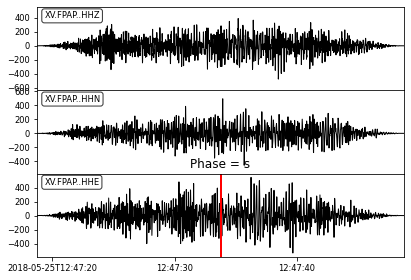

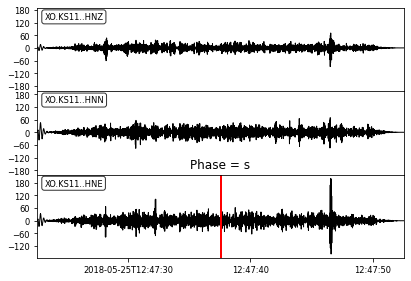

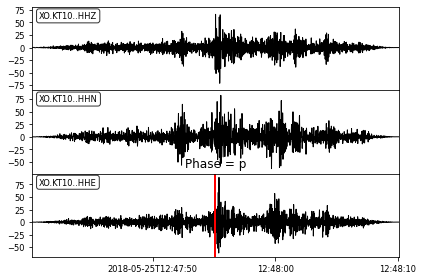

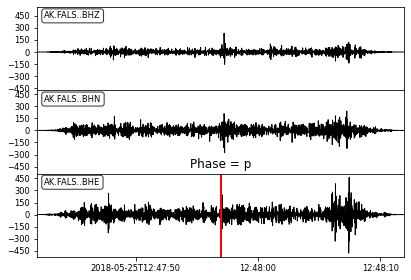

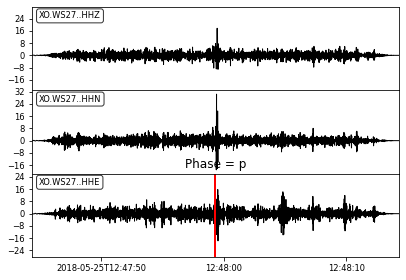

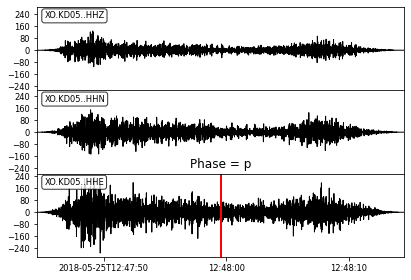

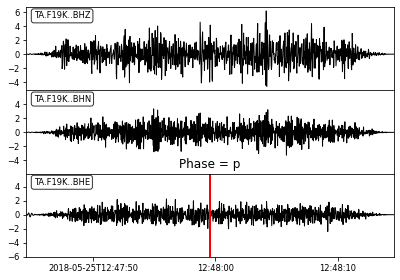

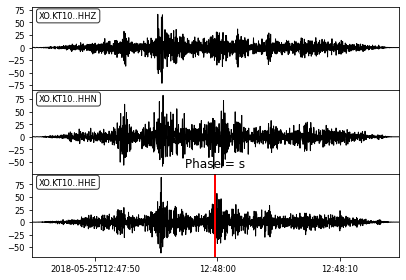

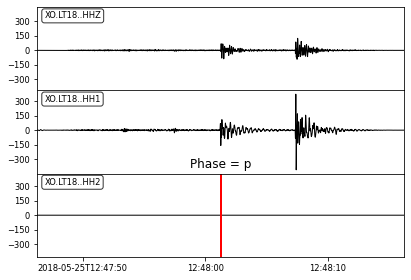

KeyboardInterrupt: 

In [19]:
# Picks that PhaseNet got but aren't in the conventional catalog:
new_picks = comp[comp['og_timestamp'].isna()]
new_picks['timestamp'] = [obspy.UTCDateTime(t) for t in new_picks['timestamp']]

client = Client("iris")
interval = 30 #s
#starttime = new_picks.iloc[0].timestamp
#endtime = starttime + interval
stream = obspy.Stream()
for i in range(len(new_picks)):
    txt=new_picks.iloc[i]['id']
    trace_info=txt.split('.')
    starttime = new_picks.iloc[i].timestamp-15
    endtime = starttime + interval
    # Read in waveform:
    st = client.get_waveforms(trace_info[0],trace_info[1],trace_info[2],trace_info[3]+'*', starttime, endtime,attach_response=True)
    # Do some waveform processing:
    # st.remove_response()
    # st = st.detrend("spline", order=2, dspline=5 * st[0].stats.sampling_rate)
    # st = st.filter("highpass", freq=1.0)
    st = st.filter("bandpass",freqmin=4,freqmax=35)
    
    %matplotlib inline
    fig = plt.figure()
    st.plot(fig = fig,starttime=starttime,endtime=endtime) 
    plt.axvline(x=new_picks.iloc[i]['timestamp'],linewidth=2, color='r')
    plt.title('Phase = '+new_picks.iloc[i]['type'])
    plt.show()




Thoughts:

It is going to be hard to quantify whether these "new" picks are correct or not.

If they associate with an event that is already in the Alaska catalog, maybe we count them as good?

I think it would be good to run an entire month (or week?) of the Alaska data through QuakeFlow.

Then we could get precision, recall, and F1-score, simply to see how well QuakeFlow performed on the already existing picks.

But then it is likely we would get some new picks- how do we evaluate these?

## GOAL 2: evaluate association performance

Start by just looking at the locations of the earthquakes on a map

## TO-DO: plot both on one map

In [261]:
time = [p.origins[0].time for p in cat.events]
lat = [p.origins[0].latitude for p in cat.events]
lon = [p.origins[0].longitude for p in cat.events]
depth = [p.origins[0].depth for p in cat.events]

cat_dict = {"lat":lat,"lon":lon,"depth":depth}

cat_dict = {"lat":lat,"lon":lon,"depth":depth}
cat_df = pd.DataFrame.from_dict(cat_dict)
og_gf = gpd.GeoDataFrame(cat_df.copy(), 
                      geometry=gpd.points_from_xy(cat_df.lon, cat_df.lat),
                      crs=4326)

cat_df = pd.DataFrame.from_dict(catalog_gamma)
gf = gpd.GeoDataFrame(cat_df.copy(),geometry=gpd.points_from_xy(cat_df.longitude, cat_df.latitude),
                      crs=4326)

og_gf.explore()
# gf.explore()

## TO-DO: match up earthquakes based on timing, and for a common event, plot the two different locations but also the different stations that had arrivals - with colors based on true and false positives

In [24]:
# Load master station list
dfS = pd.read_parquet('https://github.com/zoekrauss/alaska_catalog/raw/main/data_acquisition/alaska_stations.parquet')

# Convert to pandas datetime
dfS['start_date']=pd.to_datetime(dfS['start_date'],infer_datetime_format=True,errors='coerce')
dfS['end_date']=pd.to_datetime(dfS['end_date'],infer_datetime_format=True,errors='coerce')

In [29]:
import alaska_utils

t1 = datetime.datetime(2018,5,25,12,36,30)
t2 = t1 + pd.Timedelta(30,'minutes')

sub = alaska_utils.station_list(dfS,t1,t2,elevation=300)

In [33]:
%%time
config = {}
config["xlim_degree"] = [-170,-140]
config["ylim_degree"] = [52,58]

GAMMA_API_URL = "http://gamma.quakeflow.com"

# stations_json = json.loads(station_locs.to_json(orient="records"))
flat_sub = sub.copy()
flat_sub['start_date'] = flat_sub['start_date'].dt.strftime('%Y-%m-%d')
flat_sub['end_date'] = flat_sub['end_date'].dt.strftime('%Y-%m-%d')
stations_json = flat_sub.to_dict(orient="records")
config_gamma = {'xlim_degree': config["xlim_degree"], 
                'ylim_degree': config["ylim_degree"],
                'z(km)': [0, 41]}

result = requests.post(f'{GAMMA_API_URL}/predict', json= {"picks": phasenet_picks, 
                                                          "stations": stations_json,
                                                           "config": config_gamma})

result = result.json()



CPU times: user 14.8 ms, sys: 3.47 ms, total: 18.2 ms
Wall time: 399 ms
